In [1]:
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark.sql.types import FloatType
from pyspark.sql.types import IntegerType
from pyspark.ml.clustering import BisectingKMeans
from pyspark.ml.feature import VectorAssembler
import matplotlib.pyplot as plt
from pyspark.ml.clustering import KMeans
from pyspark.sql.functions import *
import pandas as pd
import numpy as np

In [2]:
# start spark
conf = SparkConf().setAppName("C1").setMaster("local[*]")
sc = SparkContext(conf = conf)
spark = SparkSession(sc)

In [3]:
sc=spark.sparkContext
spark = SparkSession(sc)

In [4]:
data = spark.read.text("C1.txt")

In [5]:
df1 = data.withColumn('value', ltrim(data.value))
df2 = df1.withColumn('value', regexp_replace('value', '[ ]+', ','))
df = df2.withColumn("x", split(col("value"), ",").getItem(0)).withColumn("y", split(col("value"), ",").getItem(1))
df2 = df.select("x", "y")
df2 = df2.withColumn("x", df2["x"].cast(IntegerType()))
df2 = df2.withColumn("y", df2["y"].cast(IntegerType()))
# add id column for processing by kmeans
df3 = df2.select("*").withColumn("id", monotonically_increasing_id())
df4 = df3.select("id", "x", "y")
df4.show()

+---+------+------+
| id|     x|     y|
+---+------+------+
|  0|624474|837604|
|  1|673412|735362|
|  2|647442|677000|
|  3|532283|741384|
|  4|646529|742844|
|  5|647535|755101|
|  6|644131|777721|
|  7|521368|736923|
|  8|688940|798967|
|  9|592666|805244|
| 10|645068|716248|
| 11|666740|707391|
| 12|662064|644958|
| 13|630628|689662|
| 14|623268|774834|
| 15|617896|766560|
| 16|560260|629298|
| 17|595728|703618|
| 18|594177|665266|
| 19|544862|802997|
+---+------+------+
only showing top 20 rows



In [6]:
# prepare feature column for kmeans processing
FEATURES_COL = ['x', 'y']
vecAssembler = VectorAssembler(inputCols=FEATURES_COL, outputCol="features")
new_df = vecAssembler.transform(df4).select('id',"x", "y", 'features')
new_df.show()

+---+------+------+-------------------+
| id|     x|     y|           features|
+---+------+------+-------------------+
|  0|624474|837604|[624474.0,837604.0]|
|  1|673412|735362|[673412.0,735362.0]|
|  2|647442|677000|[647442.0,677000.0]|
|  3|532283|741384|[532283.0,741384.0]|
|  4|646529|742844|[646529.0,742844.0]|
|  5|647535|755101|[647535.0,755101.0]|
|  6|644131|777721|[644131.0,777721.0]|
|  7|521368|736923|[521368.0,736923.0]|
|  8|688940|798967|[688940.0,798967.0]|
|  9|592666|805244|[592666.0,805244.0]|
| 10|645068|716248|[645068.0,716248.0]|
| 11|666740|707391|[666740.0,707391.0]|
| 12|662064|644958|[662064.0,644958.0]|
| 13|630628|689662|[630628.0,689662.0]|
| 14|623268|774834|[623268.0,774834.0]|
| 15|617896|766560|[617896.0,766560.0]|
| 16|560260|629298|[560260.0,629298.0]|
| 17|595728|703618|[595728.0,703618.0]|
| 18|594177|665266|[594177.0,665266.0]|
| 19|544862|802997|[544862.0,802997.0]|
+---+------+------+-------------------+
only showing top 20 rows



kmeans++

In [8]:
cost = np.zeros(25)
K = range(2, 25)
for k in K:
    pkm = KMeans(initMode='k-means||').setK(k).setSeed(1).setFeaturesCol("features")
    model = pkm.fit(new_df)
    cost[k] = model.summary.trainingCost

Text(0.5, 1.0, 'Kmeans Cost C1')

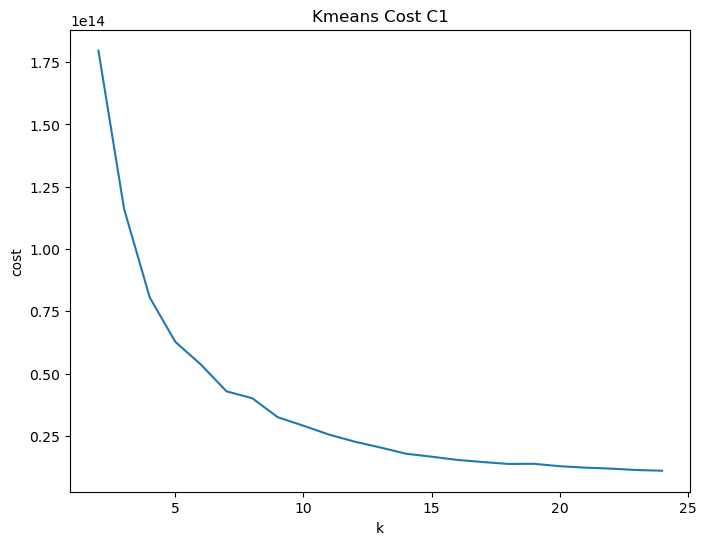

In [9]:
# plot cost-cluster diagram
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,25),cost[2:25])
ax.set_xlabel('k')
ax.set_ylabel('cost')
plt.title('Kmeans Cost C1')

In [10]:
k = 7
pkm = KMeans(initMode='k-means||').setK(k).setFeaturesCol("features")
model = pkm.fit(new_df)
centers = model.clusterCenters()
transformed=model.transform(new_df)
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[423921.20657895 707785.50526316]
[629427.92389853 693029.64485981]
[327965.05147059 306608.96764706]
[746910.45494186 488865.78197674]
[516619.14583333 471710.75416667]
[284379.89816124 518658.02263083]
[591171.92816092 254900.55747126]


In [11]:
dfcent = pd.DataFrame(centers, columns=['x', 'y'])
dfp = new_df.toPandas()
dfp=dfp.iloc[:, [1,2]].values
y_kmeans=transformed.toPandas()['prediction']

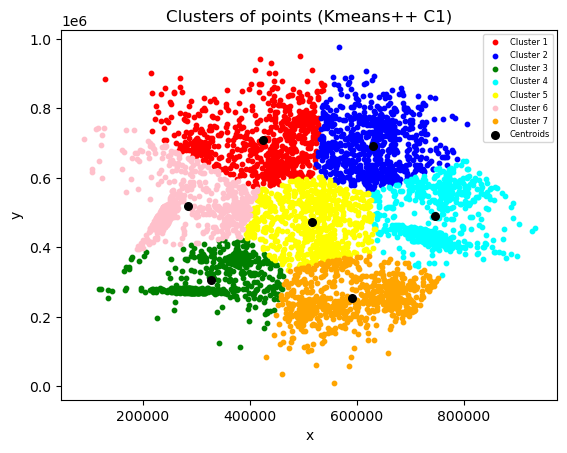

In [12]:
#6 Visualising the clusters
plt.scatter(dfp[y_kmeans==0, 0], dfp[y_kmeans==0, 1], s=10, c='red', label ='Cluster 1')
plt.scatter(dfp[y_kmeans==1, 0], dfp[y_kmeans==1, 1], s=10, c='blue', label ='Cluster 2')
plt.scatter(dfp[y_kmeans==2, 0], dfp[y_kmeans==2, 1], s=10, c='green', label ='Cluster 3')
plt.scatter(dfp[y_kmeans==3, 0], dfp[y_kmeans==3, 1], s=10, c='cyan', label ='Cluster 4')
plt.scatter(dfp[y_kmeans==4, 0], dfp[y_kmeans==4, 1], s=10, c='yellow', label ='Cluster 5')
plt.scatter(dfp[y_kmeans==5, 0], dfp[y_kmeans==5, 1], s=10, c='pink', label ='Cluster 6')
plt.scatter(dfp[y_kmeans==6, 0], dfp[y_kmeans==6, 1], s=10, c='orange', label ='Cluster 7')

plt.scatter(dfcent['x'], dfcent['y'], s=30, c='black', label = 'Centroids')
plt.title('Clusters of points (Kmeans++ C1)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(prop={'size': 6})
plt.show()

BisectingKMeans

In [14]:
from pyspark.ml.clustering import BisectingKMeans
cost = np.zeros(25)
K = range(2, 25)
for k in K:
    pkm = BisectingKMeans().setK(k).setFeaturesCol("features")
    model = pkm.fit(new_df)
    cost[k] = model.summary.trainingCost

Text(0.5, 1.0, 'BisectingKMeans Cost C1')

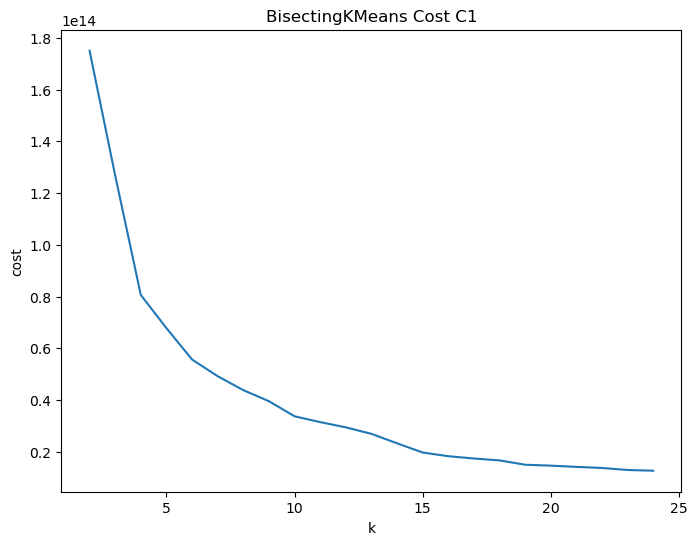

In [15]:
# plot cost-cluster diagram
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,25),cost[2:25])
ax.set_xlabel('k')
ax.set_ylabel('cost')
plt.title('BisectingKMeans Cost C1')

In [16]:
k = 6
pkm = BisectingKMeans().setK(k).setFeaturesCol("features")
model = pkm.fit(new_df)
centers = model.clusterCenters()
transformed=model.transform(new_df)
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[318943.97253635 309138.12600969]
[311612.34241245 496941.39299611]
[568247.25367287 294112.2575906 ]
[401021.08567604 652490.81793842]
[566576.7611276  746018.98071217]
[698368.94349315 531292.2380137 ]


In [17]:
dfcent = pd.DataFrame(centers, columns=['x', 'y'])
dfp = new_df.toPandas()
dfp=dfp.iloc[:, [1,2]].values
y_kmeans=transformed.toPandas()['prediction']

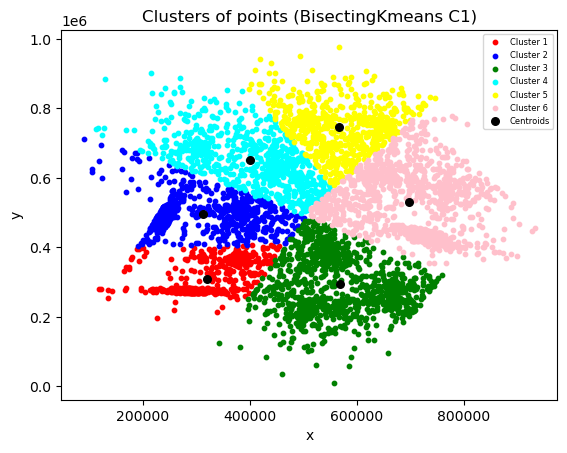

In [18]:
#6 Visualising the clusters
plt.scatter(dfp[y_kmeans==0, 0], dfp[y_kmeans==0, 1], s=10, c='red', label ='Cluster 1')
plt.scatter(dfp[y_kmeans==1, 0], dfp[y_kmeans==1, 1], s=10, c='blue', label ='Cluster 2')
plt.scatter(dfp[y_kmeans==2, 0], dfp[y_kmeans==2, 1], s=10, c='green', label ='Cluster 3')
plt.scatter(dfp[y_kmeans==3, 0], dfp[y_kmeans==3, 1], s=10, c='cyan', label ='Cluster 4')
plt.scatter(dfp[y_kmeans==4, 0], dfp[y_kmeans==4, 1], s=10, c='yellow', label ='Cluster 5')
plt.scatter(dfp[y_kmeans==5, 0], dfp[y_kmeans==5, 1], s=10, c='pink', label ='Cluster 6')

plt.scatter(dfcent['x'], dfcent['y'], s=30, c='black', label = 'Centroids')
plt.title('Clusters of points (BisectingKmeans C1)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(prop={'size': 6})
plt.show()

In [23]:
import time
list=[]
for i in range(1,5):
    j=1
    start_time = time.time()
    spark=SparkSession.builder.master("local["+str(j)+"]").appName("C1").getOrCreate()
    sc=spark.sparkContext
    data = spark.read.text("C1.txt")
    df1 = data.withColumn('value', ltrim(data.value))
    df2 = df1.withColumn('value', regexp_replace('value', '[ ]+', ','))
    df = df2.withColumn("x", split(col("value"), ",").getItem(0)).withColumn("y", split(col("value"), ",").getItem(1))
    df2 = df.select("x", "y")
    df2 = df2.withColumn("x", df2["x"].cast(IntegerType()))
    df2 = df2.withColumn("y", df2["y"].cast(IntegerType()))
    # add id column for processing by kmeans
    df3 = df2.select("*").withColumn("id", monotonically_increasing_id())
    df4 = df3.select("id", "x", "y")
    FEATURES_COL = ['x', 'y']
    vecAssembler = VectorAssembler(inputCols=FEATURES_COL, outputCol="features")
    new_df = vecAssembler.transform(df4).select('id',"x", "y", 'features')
    k = 7
    pkm = KMeans(initMode='k-means||').setK(k).setFeaturesCol("features")
    model = pkm.fit(new_df)
    print("The number of cores: ",i,", Execution time: ","%s seconds" % (time.time() - start_time))
    list.append((time.time() - start_time))

The number of cores:  1 , Execution time:  1.2574806213378906 seconds
The number of cores:  2 , Execution time:  1.1510484218597412 seconds
The number of cores:  3 , Execution time:  1.1441707611083984 seconds
The number of cores:  4 , Execution time:  1.0729405879974365 seconds


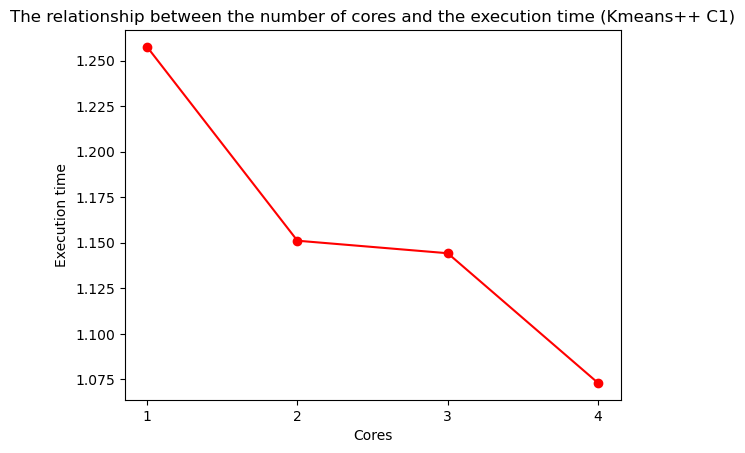

In [24]:
import matplotlib.pyplot as plt
core = ['1','2','3','4']
plt.plot(core, list,marker = 'o',c='red')
plt.xlabel('Cores')
plt.ylabel('Execution time')
plt.title('The relationship between the number of cores and the execution time (Kmeans++ C1)')
plt.show()

In [25]:
import time
list=[]
for i in range(1,5):
    j=1
    start_time = time.time()
    spark=SparkSession.builder.master("local["+str(j)+"]").appName("C1").getOrCreate()
    sc=spark.sparkContext
    data = spark.read.text("C1.txt")
    df1 = data.withColumn('value', ltrim(data.value))
    df2 = df1.withColumn('value', regexp_replace('value', '[ ]+', ','))
    df = df2.withColumn("x", split(col("value"), ",").getItem(0)).withColumn("y", split(col("value"), ",").getItem(1))
    df2 = df.select("x", "y")
    df2 = df2.withColumn("x", df2["x"].cast(IntegerType()))
    df2 = df2.withColumn("y", df2["y"].cast(IntegerType()))
    # add id column for processing by kmeans
    df3 = df2.select("*").withColumn("id", monotonically_increasing_id())
    df4 = df3.select("id", "x", "y")
    FEATURES_COL = ['x', 'y']
    vecAssembler = VectorAssembler(inputCols=FEATURES_COL, outputCol="features")
    new_df = vecAssembler.transform(df4).select('id',"x", "y", 'features')
    k = 6
    pkm = BisectingKMeans().setK(k).setFeaturesCol("features")
    model = pkm.fit(new_df)
    print("The number of cores: ",i,", Execution time: ","%s seconds" % (time.time() - start_time))
    list.append((time.time() - start_time))

The number of cores:  1 , Execution time:  2.448320150375366 seconds
The number of cores:  2 , Execution time:  2.327831745147705 seconds
The number of cores:  3 , Execution time:  2.2541892528533936 seconds
The number of cores:  4 , Execution time:  2.2072691917419434 seconds


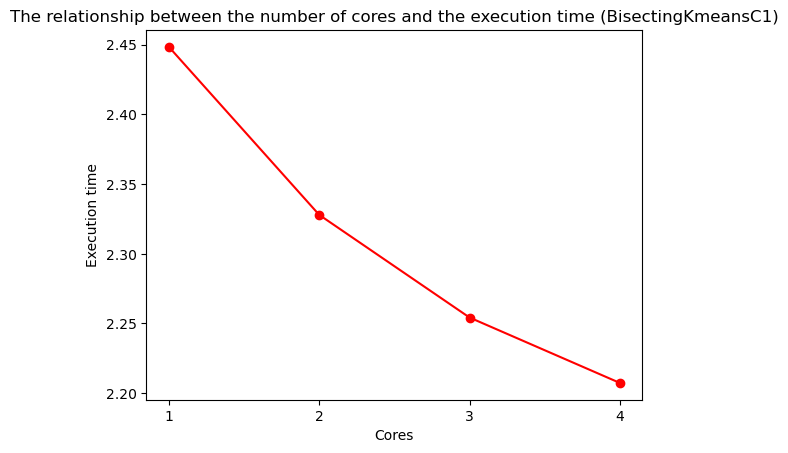

In [26]:
import matplotlib.pyplot as plt
core = ['1','2','3','4']
plt.plot(core, list,marker = 'o',c='red')
plt.xlabel('Cores')
plt.ylabel('Execution time')
plt.title('The relationship between the number of cores and the execution time (BisectingKmeansC1)')
plt.show()